# Setup enviorment

In [ ]:
%cd ..

In [2]:
from Preprocessing.time_series_preprocessing import get_dengue_dataset, train_test_split, normalize_train_features, normalize_test_features, series_to_supervised, features_labels_set, reshape_tensor

from Models.LSTM import create_model, train_model
import tensorflow as tf

from Utils.test_lstm import evaluate, plot_predictions, calculate_mean_std

import pandas as pd
import os
import numpy as np

In [3]:
""" Read Dataset:"""

embeddings = 'Embeddings/variational_autoencoder_Per_Band/224_band6.csv'
labels = '../Tabular_data/dengue_tabular.csv'

# Get list of municipalities:
Municipalities = list(pd.unique(pd.read_csv(embeddings)['Municipality Code']))

""" Dataset Preprocessing:"""
train_percentage = 80
T = 0
autoregressive = False
feature_range = (-1, 1)

""" Model Parameters:"""
lstm_layers=[1000, 500]
nn_layers=[250, 120, 1]
dense_acivation='relu'
recurrent_cells='LSTM'
bidirectional=False

## 1. Read Data

In [4]:
# Read dataset for top 5 municipalities
dengue_df = [get_dengue_dataset(labels_path=labels, embeddings_path=embeddings, municipality=Municipality) for Municipality in Municipalities]
type(dengue_df)

Obtaining dataframe for the city of 54001 - Cúcuta only...
Obtaining dataframe for the city of 41001 - Neiva only...
Obtaining dataframe for the city of 5001 - Medellín only...
Obtaining dataframe for the city of 50001 - Villavicencio only...
Obtaining dataframe for the city of 68001 - Bucaramanga only...
Obtaining dataframe for the city of 8001 - Barranquilla only...
Obtaining dataframe for the city of 23001 - Montería only...
Obtaining dataframe for the city of 76001 - Cali only...
Obtaining dataframe for the city of 73001 - Ibagué only...
Obtaining dataframe for the city of 5360 - Itagüí only...


list

### Train Test split

In [5]:
train_df = []
test_df = []

for i in range(len(dengue_df)):
    train_df_aux, test_df_aux = train_test_split(dengue_df[i], train_percentage)
    train_df.append(train_df_aux)
    test_df.append(test_df_aux)
#test_df

The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)


### Normalize features

In [6]:
# Merge:
train_df = pd.concat(train_df, keys=Municipalities)
test_df = pd.concat(test_df, keys=Municipalities)

In [7]:
# Scale train:
train_df, scalers = normalize_train_features(train_df, feature_range=feature_range)
train_df = [train_df[train_df.index.get_level_values(0) == municipality] for municipality in Municipalities]

#print(f'The scalers are: {scalers}')

train_df[1].head()

0         1         2         3         4         5  \
41001 201546  0.183307  0.148690 -0.597634  0.060217 -0.194558 -0.223471   
      201547 -0.129974 -0.071928  0.184020 -0.233271  0.096722  0.237918   
      201548 -0.521650 -0.139274 -0.159454  0.234645  0.089041  0.456092   
      201549 -0.019307  0.090942  0.149052 -0.090542  0.347196  0.045537   
      201550 -0.178440  0.472835  0.514601  0.236708 -0.026099  0.362852   

                     6         7         8         9  ...      1015      1016  \
41001 201546  0.656143 -0.046796  0.181303  0.073961  ... -0.415998  0.148518   
      201547 -0.428190  0.353940  0.097517  0.695385  ...  0.139451  0.417709   
      201548  0.582393 -0.157395  0.321132  0.024883  ... -0.215173  0.143420   
      201549  0.718921  0.537124  0.008714  0.261908  ...  0.597969  0.018001   
      201550 -0.019355 -0.141841 -0.418779  0.987510  ...  0.270976  0.023398   

                  1017      1018      1019      1020      1021      1022  \
41001 201546  0.017165  0.102138  0.044118  0.342764  0.382407 -0.434226   
      201547  0.047166 -0.047149 -0.312497  0.315334  0.220142 -0.429866   
      201548 -0.310988  0.567720 -0.378382 -0.299016  0.325079 -0.808105   
      201549  0.117120  0.414088 -0.294998 -0.134851  0.165739  0.304723   
      201550  0.314960  0.097831  0.076818  0.051084 -0.105544  0.119834   

                  1023    Labels  
41001 201546 -0.277833 -0.861740  
      201547 -0.702961 -0.854589  
      201548 -0.032345 -0.856973  
      201549 -0.316577 -0.856973  
      201550  0.228517 -0.823600  

[5 rows x 1025 columns]

In [8]:
# Scale test:
test_df = normalize_test_features(test_df, scalers=scalers)
test_df = [test_df[test_df.index.get_level_values(0) == municipality] for municipality in Municipalities]

test_df[1].head()

0         1         2         3         4         5  \
41001 201820 -0.153325 -0.121392  0.011541 -0.252867  0.304550  0.264449   
      201821 -0.224559  0.022747  0.015132 -0.010542 -0.109602 -0.331886   
      201822  0.723637  0.461527  0.321692  0.014465 -0.141173  0.015522   
      201823 -0.112426 -0.087390  0.198259 -0.377222 -0.129921 -0.042315   
      201824  0.325484  0.086819  0.805320  0.138934 -0.199998  0.080343   

                     6         7         8         9  ...      1015      1016  \
41001 201820 -0.041075 -0.186160  0.263571  0.192705  ...  0.309667  0.408769   
      201821  0.591583  0.033680 -0.427027 -0.072073  ...  0.461550 -0.122139   
      201822  0.607128 -0.164977  0.110238  0.522589  ... -0.085786  0.178294   
      201823 -0.459001 -0.234543  0.206635 -0.579227  ...  0.591743  0.150696   
      201824  0.089236 -0.028030  0.066013 -0.082904  ... -0.213103 -0.201926   

                  1017      1018      1019      1020      1021      1022  \
41001 201820  0.409743 -0.110768  0.196587 -0.178969 -0.246193 -0.797433   
      201821  0.381058 -0.029720 -0.111095  0.115791 -0.237290 -0.307205   
      201822 -0.011664  0.120238  0.232528  0.044432  0.170914 -0.200761   
      201823 -0.343435 -0.070425 -0.099915  0.611242 -0.161632  0.029188   
      201824  0.697185 -0.032376  0.045738 -0.061919  0.087146 -0.302724   

                  1023    Labels  
41001 201820 -0.017118 -0.949940  
      201821 -0.454022 -0.961859  
      201822  0.095229 -0.940405  
      201823 -0.240057 -0.961859  
      201824 -0.548014 -0.954708  

[5 rows x 1025 columns]

### Prepare data for time series supervised learning (function to create sliding window)

In [9]:
# frame as supervised learning
train = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in train_df]
test = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in test_df]

train[1].shape

(130, 1025)

### Merge train data

In [10]:
# Merge:
train = pd.concat(train, keys=Municipalities)
test = pd.concat(test, keys=Municipalities)

In [11]:
train.shape

(1300, 1025)

### Features and Labels Set

In [12]:
# Train features and labels set
print('Train:')
train_X, train_y, n_features = features_labels_set(timeseries_data=train, original_df=dengue_df[0], autoregressive=autoregressive)

# Test features and labels set
print('Test:')
test_X, test_y, n_features = features_labels_set(timeseries_data=test, original_df=dengue_df[0], autoregressive=autoregressive)

Train:
The shape of the features is (1300, 1024)
The shape of the labels is (1300, 1)
Test:
The shape of the features is (330, 1024)
The shape of the labels is (330, 1)


In [13]:
# reshape input to be 3D [samples, timesteps, features]
if T != 0:
    train_X, test_X = reshape_tensor(train_X, test_X, n_features, T, autoregressive)

# 2. Model

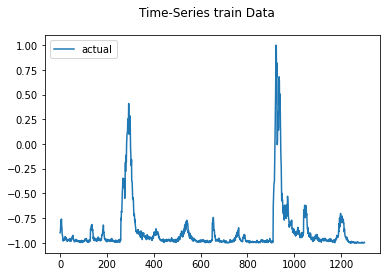

2023-03-14 14:14:32.511987: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-14 14:14:32.512027: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-14 14:14:32.512049: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (9e0b1a08816a): /proc/driver/nvidia/version does not exist
2023-03-14 14:14:32.512258: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-14 14:14:32.582983: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] 

Test MAE: 45.610
Test RMSE: 54.584
Test sMAPE: 103.526
Test R Squared: -2.083
{'mae': 45.60969000368407, 'rmse': 54.58424882183784, 'smape': 103.52601123316157, 'r2': -2.083022382432115}


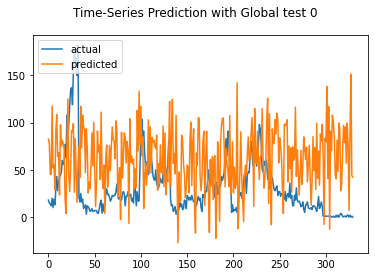

Test MAE: 47.241
Test RMSE: 57.370
Test sMAPE: 105.821
Test R Squared: -2.406
{'mae': 47.24143634619135, 'rmse': 57.36983968927546, 'smape': 105.82090846502994, 'r2': -2.4057226236521676}


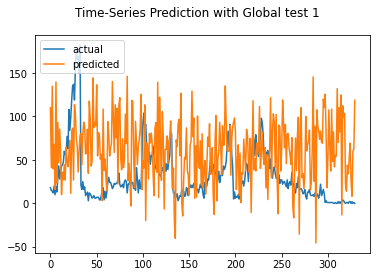

Test MAE: 56.266
Test RMSE: 65.432
Test sMAPE: 107.115
Test R Squared: -3.430
{'mae': 56.26585499590094, 'rmse': 65.43201046156179, 'smape': 107.11513698229285, 'r2': -3.430191820391995}


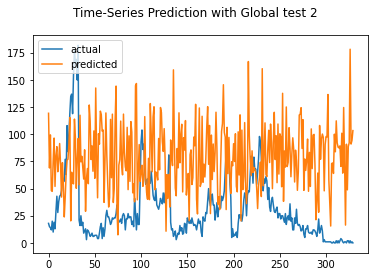

Test MAE: 37.701
Test RMSE: 48.058
Test sMAPE: 98.375
Test R Squared: -1.390
{'mae': 37.7014707532796, 'rmse': 48.058329509819224, 'smape': 98.37468691303685, 'r2': -1.3898978760554082}


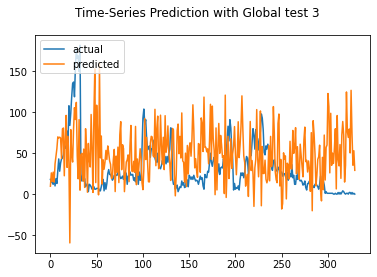

Test MAE: 36.759
Test RMSE: 47.519
Test sMAPE: 100.253
Test R Squared: -1.337
{'mae': 36.75853817282301, 'rmse': 47.51918121847056, 'smape': 100.25319171708634, 'r2': -1.3365759350329243}


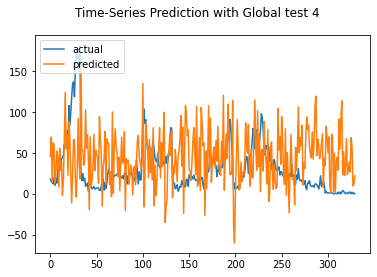

Test MAE: 44.727
Test RMSE: 52.526
Test sMAPE: 100.686
Test R Squared: -1.855
{'mae': 44.72671895460649, 'rmse': 52.52639899922214, 'smape': 100.68568519687904, 'r2': -1.8549417936703252}


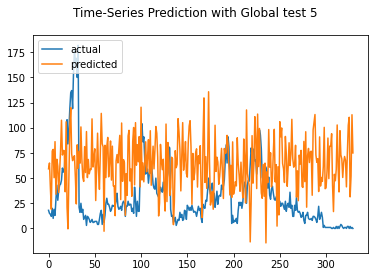

Test MAE: 34.879
Test RMSE: 44.517
Test sMAPE: 99.610
Test R Squared: -1.051
{'mae': 34.87892170042703, 'rmse': 44.51709606490804, 'smape': 99.61028672709725, 'r2': -1.0506694197275612}


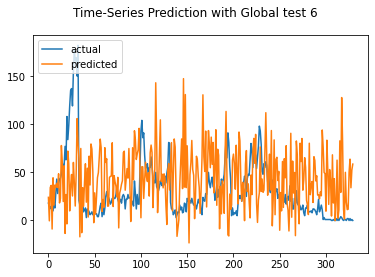

Test MAE: 54.002
Test RMSE: 63.903
Test sMAPE: 107.283
Test R Squared: -3.226
{'mae': 54.00176997257002, 'rmse': 63.903239187228635, 'smape': 107.28286216076167, 'r2': -3.225593802942809}


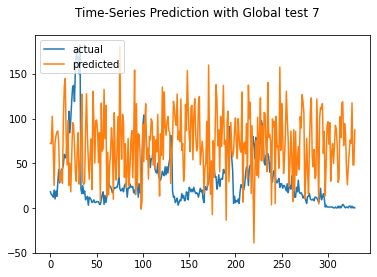

Test MAE: 71.227
Test RMSE: 81.238
Test sMAPE: 116.867
Test R Squared: -5.829
{'mae': 71.22675908424638, 'rmse': 81.23800084835419, 'smape': 116.86728396140393, 'r2': -5.829052581422165}


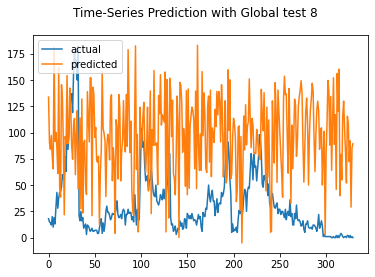

Test MAE: 62.656
Test RMSE: 71.958
Test sMAPE: 111.596
Test R Squared: -4.358
{'mae': 62.656053480957496, 'rmse': 71.95803441185127, 'smape': 111.5962338749168, 'r2': -4.357973794487142}


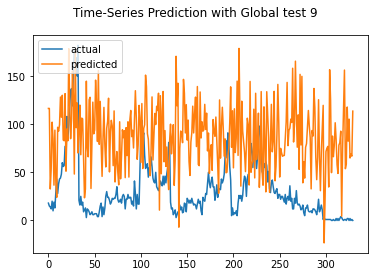

Test MAE: 62.157
Test RMSE: 71.012
Test sMAPE: 112.702
Test R Squared: -4.218
{'mae': 62.15708573370269, 'rmse': 71.01164060655745, 'smape': 112.70246532439126, 'r2': -4.217964192643091}


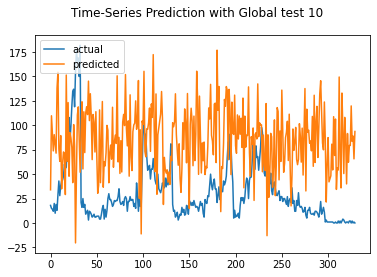

Test MAE: 57.489
Test RMSE: 67.559
Test sMAPE: 111.448
Test R Squared: -3.723
{'mae': 57.48870053291321, 'rmse': 67.55916859879966, 'smape': 111.44807486763983, 'r2': -3.722920056256063}


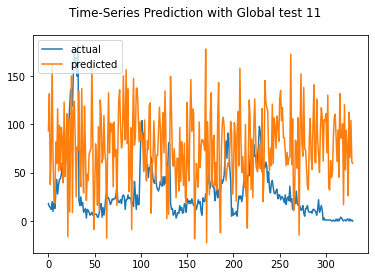

Test MAE: 65.433
Test RMSE: 73.822
Test sMAPE: 113.869
Test R Squared: -4.639
{'mae': 65.43329157973781, 'rmse': 73.82210131083426, 'smape': 113.86852850810581, 'r2': -4.639165073047152}


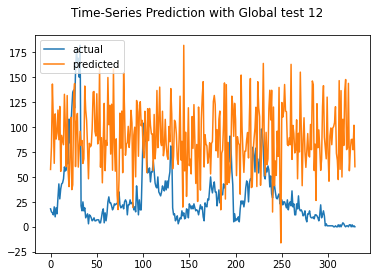

Test MAE: 52.958
Test RMSE: 61.335
Test sMAPE: 105.280
Test R Squared: -2.893
{'mae': 52.957774085709545, 'rmse': 61.33507244599933, 'smape': 105.28020710437568, 'r2': -2.8927791619978143}


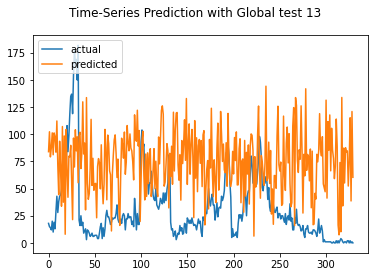

Test MAE: 56.839
Test RMSE: 66.839
Test sMAPE: 107.428
Test R Squared: -3.623
{'mae': 56.83883957429366, 'rmse': 66.83875576440653, 'smape': 107.42840630962887, 'r2': -3.6227319876438058}


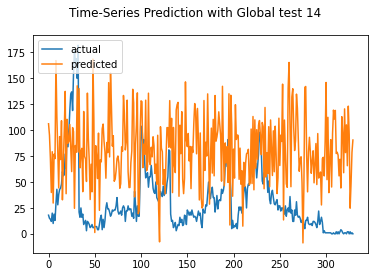

Test MAE: 49.072
Test RMSE: 59.648
Test sMAPE: 104.559
Test R Squared: -2.682
{'mae': 49.07226597973795, 'rmse': 59.64771247048172, 'smape': 104.55902727629314, 'r2': -2.681540541633218}


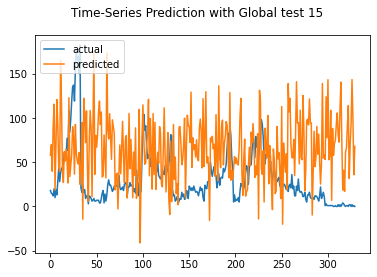

Test MAE: 55.895
Test RMSE: 64.273
Test sMAPE: 108.895
Test R Squared: -3.275
{'mae': 55.895063837369285, 'rmse': 64.27330032562753, 'smape': 108.89487982577892, 'r2': -3.2746760033703053}


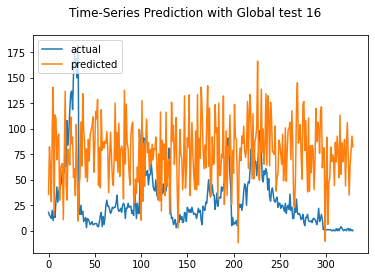

Test MAE: 52.548
Test RMSE: 60.866
Test sMAPE: 105.971
Test R Squared: -2.833
{'mae': 52.54751971851696, 'rmse': 60.86571633354777, 'smape': 105.97088368069103, 'r2': -2.8334294673403098}


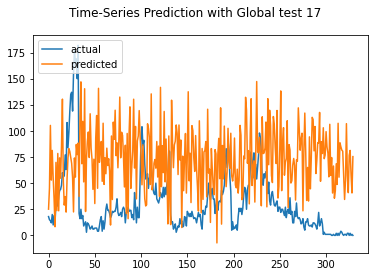

Test MAE: 62.001
Test RMSE: 70.269
Test sMAPE: 111.290
Test R Squared: -4.109
{'mae': 62.001473819848265, 'rmse': 70.26874591324689, 'smape': 111.290400001067, 'r2': -4.109358864496707}


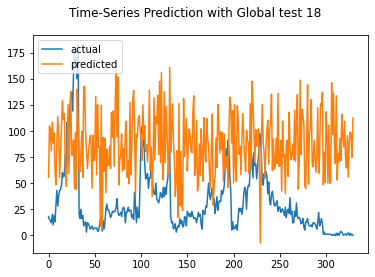

Test MAE: 42.136
Test RMSE: 51.260
Test sMAPE: 102.523
Test R Squared: -1.719
{'mae': 42.136361261570094, 'rmse': 51.26015784115813, 'smape': 102.52286657909481, 'r2': -1.718954123964016}


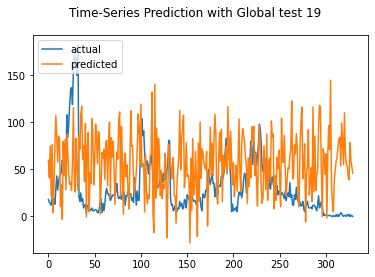

Test MAE: 72.551
Test RMSE: 81.636
Test sMAPE: 117.916
Test R Squared: -5.896
{'mae': 72.55109783158157, 'rmse': 81.63641084854386, 'smape': 117.91594662860646, 'r2': -5.896199346182916}


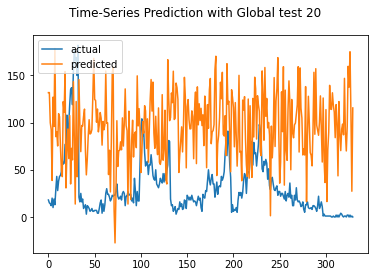

Test MAE: 41.440
Test RMSE: 50.133
Test sMAPE: 98.711
Test R Squared: -1.601
{'mae': 41.43954841006886, 'rmse': 50.13293860529065, 'smape': 98.71050581574232, 'r2': -1.6006884314434213}


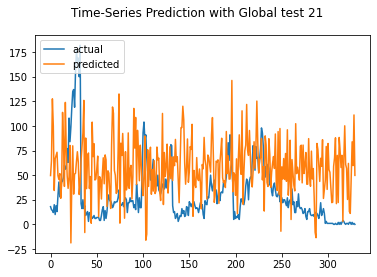

Test MAE: 44.839
Test RMSE: 54.694
Test sMAPE: 100.360
Test R Squared: -2.095
{'mae': 44.83864979509151, 'rmse': 54.69442430110197, 'smape': 100.36017119003213, 'r2': -2.0954807850870063}


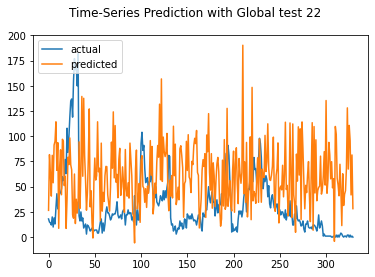

Test MAE: 55.738
Test RMSE: 65.221
Test sMAPE: 108.061
Test R Squared: -3.402
{'mae': 55.73768979509671, 'rmse': 65.22116492126612, 'smape': 108.06146279422398, 'r2': -3.40168646956798}


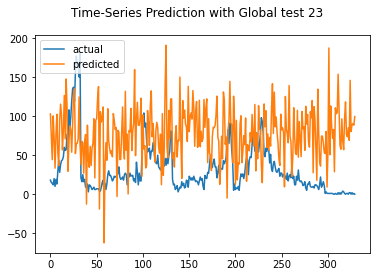

Test MAE: 48.836
Test RMSE: 58.784
Test sMAPE: 104.585
Test R Squared: -2.576
{'mae': 48.8358210809303, 'rmse': 58.78357686247698, 'smape': 104.58514315054532, 'r2': -2.575641907105199}


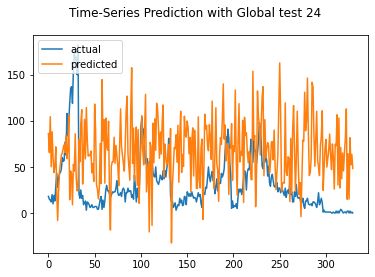

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 41.705
Test RMSE: 52.924
Test sMAPE: 105.960
Test R Squared: -1.898
{'mae': 41.70470843206753, 'rmse': 52.92413376941996, 'smape': 105.95991076257549, 'r2': -1.8983412549728254}


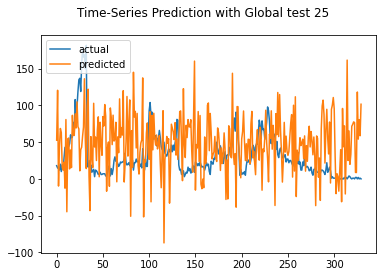

Test MAE: 42.127
Test RMSE: 51.116
Test sMAPE: 96.071
Test R Squared: -1.704
{'mae': 42.12714327375094, 'rmse': 51.116030982238456, 'smape': 96.07111658249401, 'r2': -1.7036859928275896}


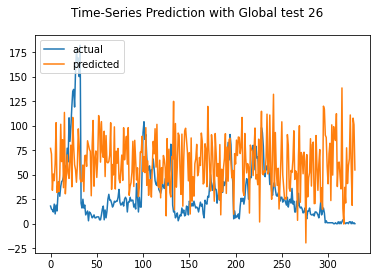

Test MAE: 40.278
Test RMSE: 51.118
Test sMAPE: 97.113
Test R Squared: -1.704
{'mae': 40.278490718567014, 'rmse': 51.11848395904646, 'smape': 97.11337468268371, 'r2': -1.7039454902118951}


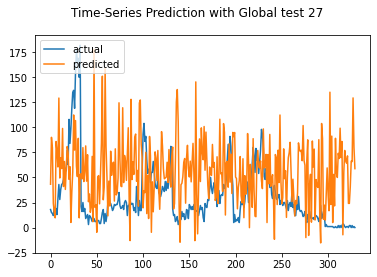

Test MAE: 39.676
Test RMSE: 48.525
Test sMAPE: 96.243
Test R Squared: -1.436
{'mae': 39.67625373060053, 'rmse': 48.524591298698496, 'smape': 96.24257106836379, 'r2': -1.436496400216161}


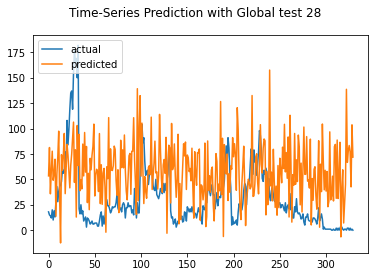

Test MAE: 64.705
Test RMSE: 74.453
Test sMAPE: 114.085
Test R Squared: -4.736
{'mae': 64.70543265487208, 'rmse': 74.4525066695207, 'smape': 114.08542968141506, 'r2': -4.735887833408355}


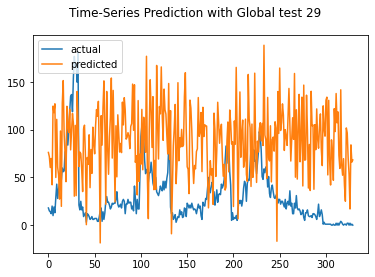

Test MAE: 68.516
Test RMSE: 76.860
Test sMAPE: 118.129
Test R Squared: -5.113
{'mae': 68.51639090595823, 'rmse': 76.86016397491844, 'smape': 118.12943872499245, 'r2': -5.112862329873308}


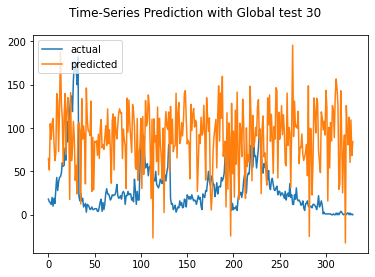

Test MAE: 45.939
Test RMSE: 55.552
Test sMAPE: 103.281
Test R Squared: -2.193
{'mae': 45.938834222067484, 'rmse': 55.55151786702249, 'smape': 103.2812948893297, 'r2': -2.1932569164628926}


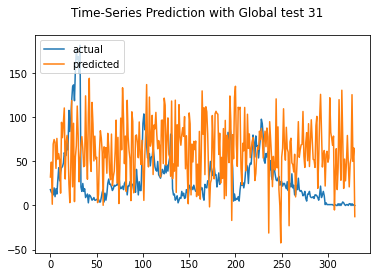

Test MAE: 61.371
Test RMSE: 69.078
Test sMAPE: 111.422
Test R Squared: -3.938
{'mae': 61.37077143770276, 'rmse': 69.0776840071526, 'smape': 111.42197130576515, 'r2': -3.9376185780527138}


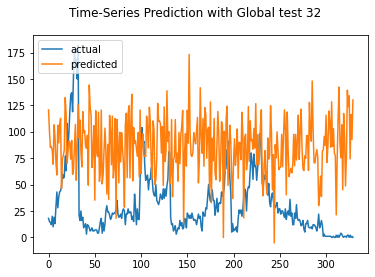

Test MAE: 39.486
Test RMSE: 48.164
Test sMAPE: 97.080
Test R Squared: -1.400
{'mae': 39.48622357213136, 'rmse': 48.16445243842053, 'smape': 97.08047190264624, 'r2': -1.4004643268976689}


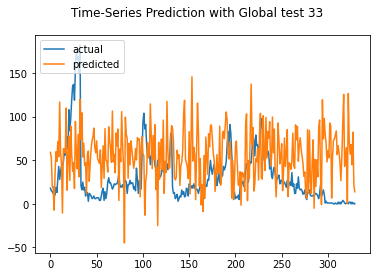

Test MAE: 71.127
Test RMSE: 80.258
Test sMAPE: 117.435
Test R Squared: -5.665
{'mae': 71.12700998421872, 'rmse': 80.2575171167348, 'smape': 117.43529461293383, 'r2': -5.665203931381701}


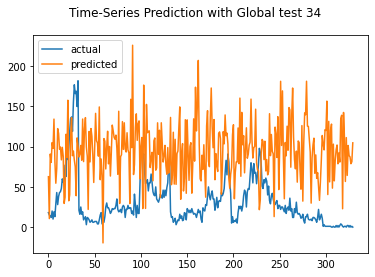

Test MAE: 45.984
Test RMSE: 54.149
Test sMAPE: 102.311
Test R Squared: -2.034
{'mae': 45.9840372746641, 'rmse': 54.14949455998655, 'smape': 102.31092595749134, 'r2': -2.034106466552769}


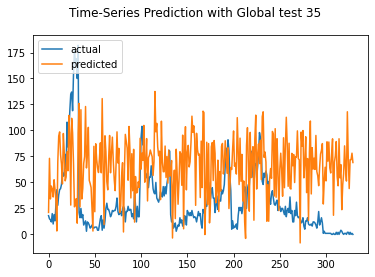

Test MAE: 49.049
Test RMSE: 57.802
Test sMAPE: 102.653
Test R Squared: -2.457
{'mae': 49.048997365705894, 'rmse': 57.801602166226694, 'smape': 102.65258057529967, 'r2': -2.45717811173837}


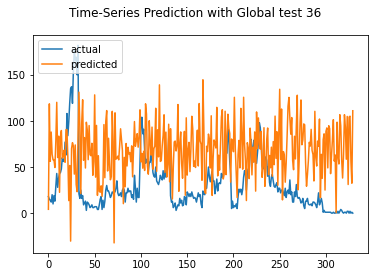

Test MAE: 43.537
Test RMSE: 53.153
Test sMAPE: 101.290
Test R Squared: -1.924
{'mae': 43.53653843330615, 'rmse': 53.15341728667514, 'smape': 101.28974347483044, 'r2': -1.9235086532441419}


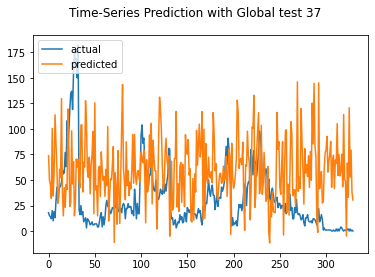

Test MAE: 60.173
Test RMSE: 69.108
Test sMAPE: 112.163
Test R Squared: -3.942
{'mae': 60.17322297312997, 'rmse': 69.1079542572225, 'smape': 112.1629123875, 'r2': -3.9419469135790326}


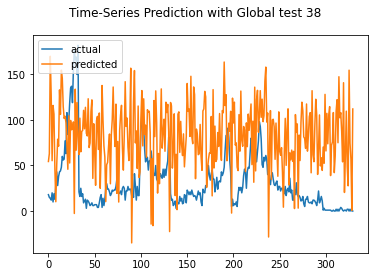

Test MAE: 59.102
Test RMSE: 68.338
Test sMAPE: 109.638
Test R Squared: -3.832
{'mae': 59.10224389162931, 'rmse': 68.33810012852034, 'smape': 109.63843001306257, 'r2': -3.8324548295313914}


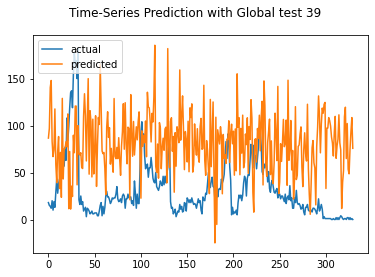

Test MAE: 48.946
Test RMSE: 57.581
Test sMAPE: 103.771
Test R Squared: -2.431
{'mae': 48.94621460835139, 'rmse': 57.581073552372985, 'smape': 103.77074629186673, 'r2': -2.430848312033822}


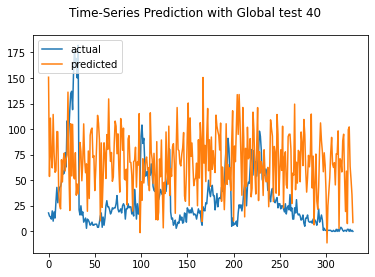

Test MAE: 40.140
Test RMSE: 50.227
Test sMAPE: 97.900
Test R Squared: -1.610
{'mae': 40.14020227690538, 'rmse': 50.22676188940814, 'smape': 97.90019501301704, 'r2': -1.6104318641228828}


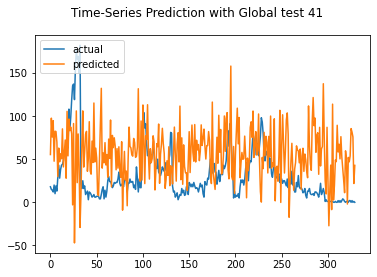

Test MAE: 67.500
Test RMSE: 74.659
Test sMAPE: 115.233
Test R Squared: -4.768
{'mae': 67.50045581586433, 'rmse': 74.65893557102702, 'smape': 115.23284073505093, 'r2': -4.767738862885342}


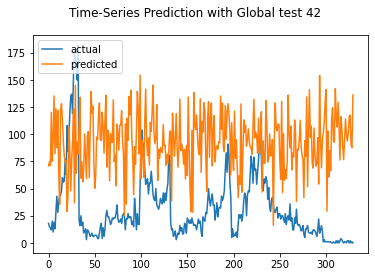

Test MAE: 45.123
Test RMSE: 55.175
Test sMAPE: 101.475
Test R Squared: -2.150
{'mae': 45.123305305928895, 'rmse': 55.17516748074747, 'smape': 101.47549094232353, 'r2': -2.1501361306037787}


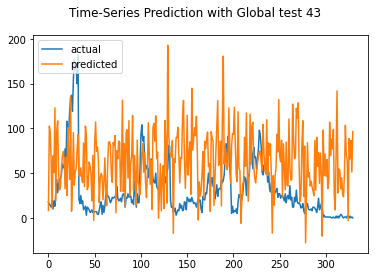

Test MAE: 53.917
Test RMSE: 64.336
Test sMAPE: 107.164
Test R Squared: -3.283
{'mae': 53.916823064377816, 'rmse': 64.33648467697245, 'smape': 107.16395016780766, 'r2': -3.283084639224061}


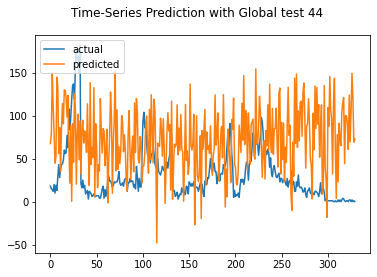

Test MAE: 43.347
Test RMSE: 52.100
Test sMAPE: 102.631
Test R Squared: -1.809
{'mae': 43.34741450114684, 'rmse': 52.099548908005765, 'smape': 102.63091049783503, 'r2': -1.8087295785924584}


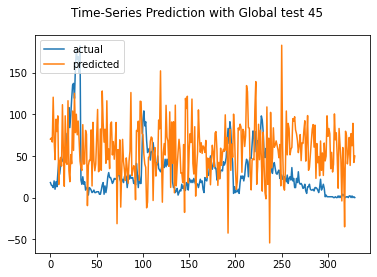

Test MAE: 48.290
Test RMSE: 56.253
Test sMAPE: 106.006
Test R Squared: -2.274
{'mae': 48.289950808973025, 'rmse': 56.25314861508397, 'smape': 106.00561302862599, 'r2': -2.2744297198923387}


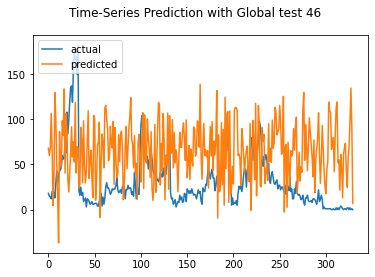

Test MAE: 40.797
Test RMSE: 51.852
Test sMAPE: 104.744
Test R Squared: -1.782
{'mae': 40.79671439293659, 'rmse': 51.85235668048504, 'smape': 104.74362355409684, 'r2': -1.7821401338794254}


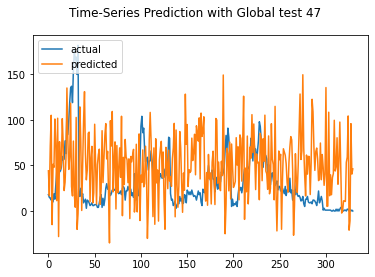

Test MAE: 52.724
Test RMSE: 61.173
Test sMAPE: 106.827
Test R Squared: -2.872
{'mae': 52.72372816873319, 'rmse': 61.17298787580866, 'smape': 106.82699605054357, 'r2': -2.8722321658706553}


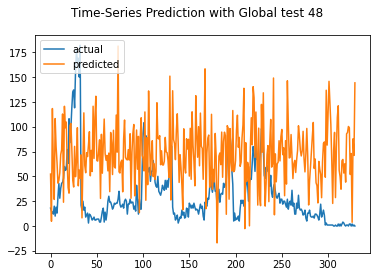

Test MAE: 41.689
Test RMSE: 50.063
Test sMAPE: 102.702
Test R Squared: -1.593
{'mae': 41.68886576475519, 'rmse': 50.063440767492104, 'smape': 102.7023479504162, 'r2': -1.5934829115218325}


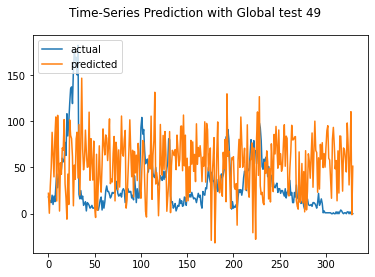

Test MAE: 37.156
Test RMSE: 47.911
Test sMAPE: 98.301
Test R Squared: -1.375
{'mae': 37.15636255885615, 'rmse': 47.910670458934014, 'smape': 98.30076551073125, 'r2': -1.3752345313676653}


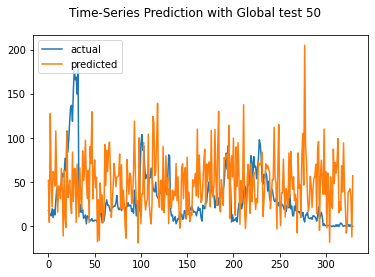

Test MAE: 47.953
Test RMSE: 57.684
Test sMAPE: 105.663
Test R Squared: -2.443
{'mae': 47.953400337334834, 'rmse': 57.68421025324084, 'smape': 105.66349972665009, 'r2': -2.4431496899453147}


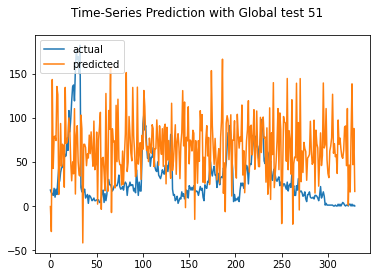

Test MAE: 45.626
Test RMSE: 54.724
Test sMAPE: 102.363
Test R Squared: -2.099
{'mae': 45.62551214442109, 'rmse': 54.7240734819222, 'smape': 102.36291228135596, 'r2': -2.0988377395367714}


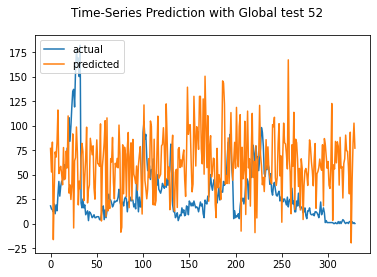

Test MAE: 48.782
Test RMSE: 60.224
Test sMAPE: 104.343
Test R Squared: -2.753
{'mae': 48.78170670198672, 'rmse': 60.22434576198103, 'smape': 104.34341761922948, 'r2': -2.7530658397221175}


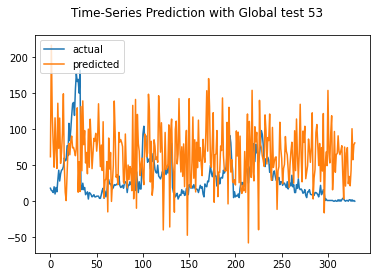

Test MAE: 36.082
Test RMSE: 44.856
Test sMAPE: 97.702
Test R Squared: -1.082
{'mae': 36.08174328009287, 'rmse': 44.85562032591902, 'smape': 97.70156564361602, 'r2': -1.0819760812944632}


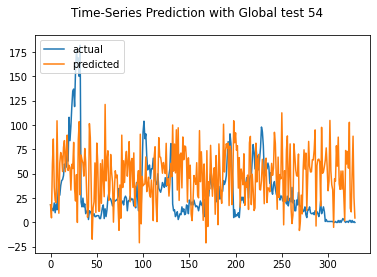

Test MAE: 81.907
Test RMSE: 91.898
Test sMAPE: 121.273
Test R Squared: -7.739
{'mae': 81.90729926788445, 'rmse': 91.898430002923, 'smape': 121.27263013837253, 'r2': -7.738928489717283}


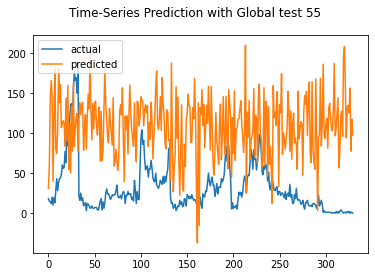

Test MAE: 46.173
Test RMSE: 56.580
Test sMAPE: 108.090
Test R Squared: -2.313
{'mae': 46.173278480406964, 'rmse': 56.58026128609245, 'smape': 108.09016641460582, 'r2': -2.3126221314778483}


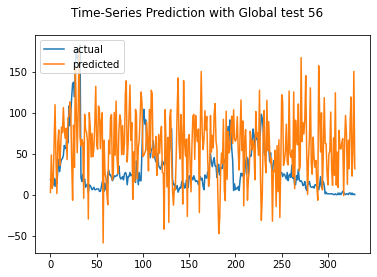

Test MAE: 63.845
Test RMSE: 73.621
Test sMAPE: 113.240
Test R Squared: -4.609
{'mae': 63.844607732512735, 'rmse': 73.62146060920469, 'smape': 113.23954656794707, 'r2': -4.608553414988776}


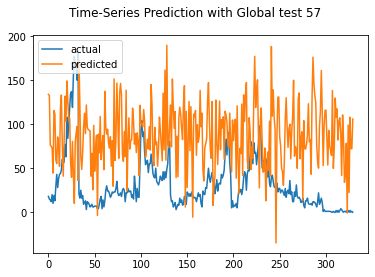

Test MAE: 45.937
Test RMSE: 55.184
Test sMAPE: 103.029
Test R Squared: -2.151
{'mae': 45.93732659311006, 'rmse': 55.184261111664725, 'smape': 103.02885743444567, 'r2': -2.1511745882020747}


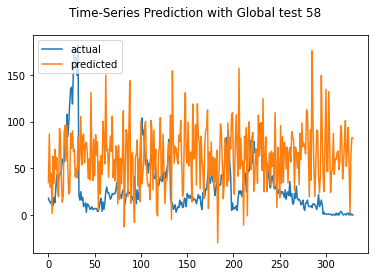

Test MAE: 39.465
Test RMSE: 48.050
Test sMAPE: 98.771
Test R Squared: -1.389
{'mae': 39.465319233771524, 'rmse': 48.050285765901, 'smape': 98.77127379893143, 'r2': -1.3890979265806793}


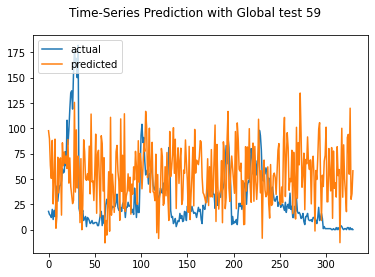

Test MAE: 46.830
Test RMSE: 55.428
Test sMAPE: 101.580
Test R Squared: -2.179
{'mae': 46.82999359315092, 'rmse': 55.42762322834476, 'smape': 101.58046349347022, 'r2': -2.1790291779620263}


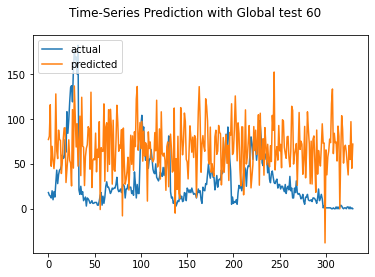

Test MAE: 41.658
Test RMSE: 51.085
Test sMAPE: 99.275
Test R Squared: -1.700
{'mae': 41.657767002510305, 'rmse': 51.08456462984691, 'smape': 99.27487550329921, 'r2': -1.700358310728336}


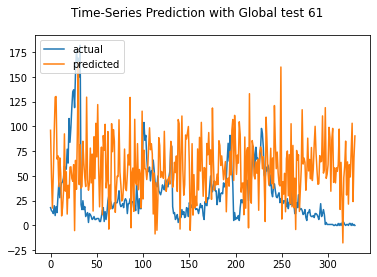

Test MAE: 37.960
Test RMSE: 49.011
Test sMAPE: 96.797
Test R Squared: -1.486
{'mae': 37.95970026254654, 'rmse': 49.01053787825637, 'smape': 96.79717705808947, 'r2': -1.48554104515124}


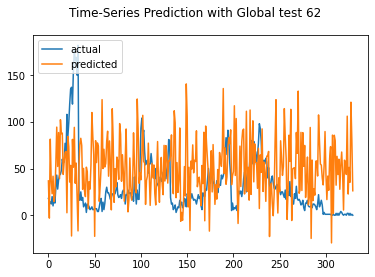

Test MAE: 39.974
Test RMSE: 50.594
Test sMAPE: 107.091
Test R Squared: -1.649
{'mae': 39.97359845855019, 'rmse': 50.5942564906223, 'smape': 107.09070420138492, 'r2': -1.6487711522603257}


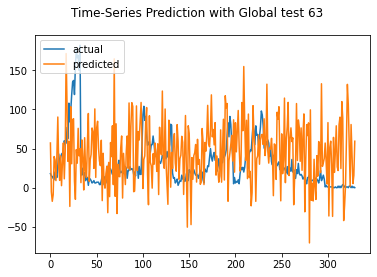

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Test MAE: 36.398
Test RMSE: 47.395
Test sMAPE: 113.352
Test R Squared: -1.324
{'mae': 36.39794402745637, 'rmse': 47.395115044493664, 'smape': 113.35162798383676, 'r2': -1.324390893239427}


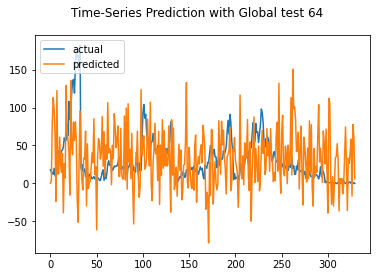

Test MAE: 53.235
Test RMSE: 61.961
Test sMAPE: 107.352
Test R Squared: -2.973
{'mae': 53.234706567272994, 'rmse': 61.96062312748612, 'smape': 107.35181134453644, 'r2': -2.9725882629005165}


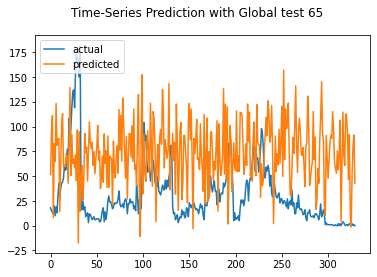

Test MAE: 38.948
Test RMSE: 48.188
Test sMAPE: 102.097
Test R Squared: -1.403
{'mae': 38.94773928649498, 'rmse': 48.188254272687495, 'smape': 102.09711100124208, 'r2': -1.4028374285830085}


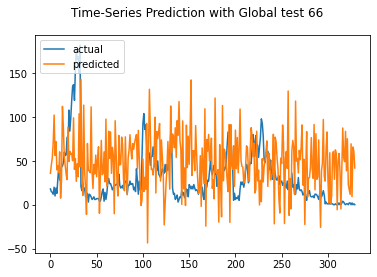

Test MAE: 41.882
Test RMSE: 51.243
Test sMAPE: 103.191
Test R Squared: -1.717
{'mae': 41.88176255081639, 'rmse': 51.24258309401647, 'smape': 103.19079225679589, 'r2': -1.7170900352992682}


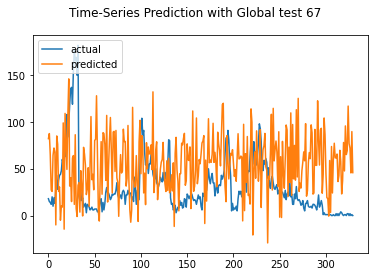

Test MAE: 56.766
Test RMSE: 65.322
Test sMAPE: 108.898
Test R Squared: -3.415
{'mae': 56.76567476229234, 'rmse': 65.32176883723005, 'smape': 108.89831957315143, 'r2': -3.4152761816614614}


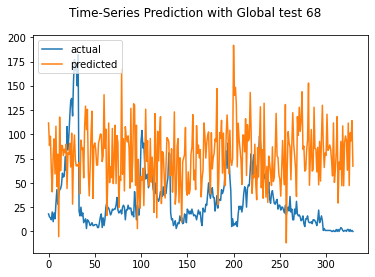

Test MAE: 47.113
Test RMSE: 57.061
Test sMAPE: 102.565
Test R Squared: -2.369
{'mae': 47.11310773257053, 'rmse': 57.061231342036216, 'smape': 102.56460724349206, 'r2': -2.3691805125971976}


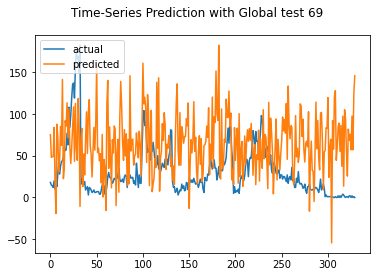

Test MAE: 41.505
Test RMSE: 52.254
Test sMAPE: 104.725
Test R Squared: -1.825
{'mae': 41.50470734220563, 'rmse': 52.253921265133734, 'smape': 104.72543321723609, 'r2': -1.8253989196663376}


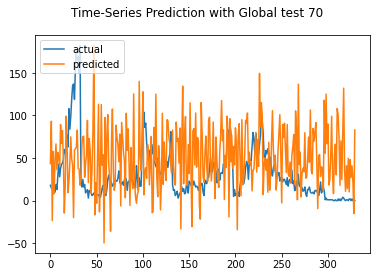

Test MAE: 54.814
Test RMSE: 64.114
Test sMAPE: 108.278
Test R Squared: -3.254
{'mae': 54.8142967608842, 'rmse': 64.11432587960867, 'smape': 108.27766852374938, 'r2': -3.2535560725614916}


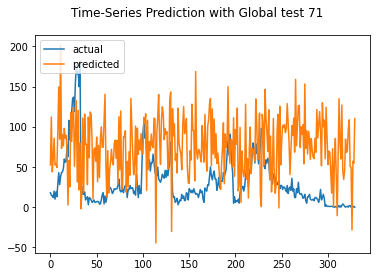

Test MAE: 62.846
Test RMSE: 72.232
Test sMAPE: 112.153
Test R Squared: -4.399
{'mae': 62.84616972244147, 'rmse': 72.23212797304237, 'smape': 112.15275668921112, 'r2': -4.398869383355701}


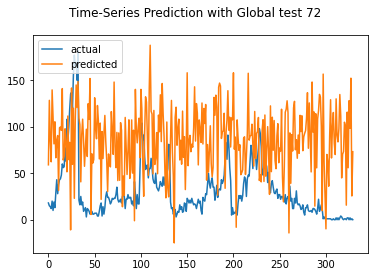

Test MAE: 53.371
Test RMSE: 62.306
Test sMAPE: 109.244
Test R Squared: -3.017
{'mae': 53.37099493344625, 'rmse': 62.30552995772784, 'smape': 109.24357683548327, 'r2': -3.0169385719576614}


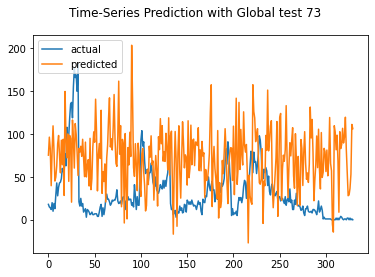

Test MAE: 46.813
Test RMSE: 56.078
Test sMAPE: 103.343
Test R Squared: -2.254
{'mae': 46.81311094399655, 'rmse': 56.07847195731424, 'smape': 103.34293166919475, 'r2': -2.254125846360398}


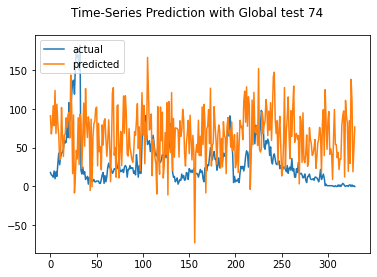

Test MAE: 48.820
Test RMSE: 59.655
Test sMAPE: 105.624
Test R Squared: -2.682
{'mae': 48.81980210578803, 'rmse': 59.65537707439687, 'smape': 105.62381990728173, 'r2': -2.682486742646732}


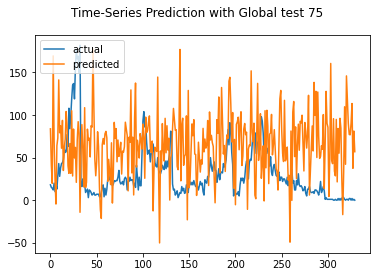

Test MAE: 59.053
Test RMSE: 68.027
Test sMAPE: 109.031
Test R Squared: -3.789
{'mae': 59.05283362269402, 'rmse': 68.02714947450826, 'smape': 109.03068358768284, 'r2': -3.7885778030529487}


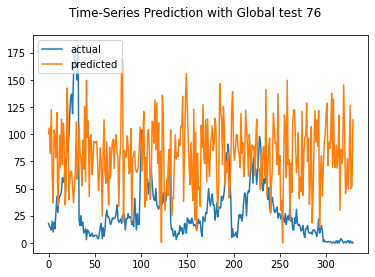

Test MAE: 41.801
Test RMSE: 51.973
Test sMAPE: 100.553
Test R Squared: -1.795
{'mae': 41.80065166155497, 'rmse': 51.972921163279004, 'smape': 100.55262885881457, 'r2': -1.7950929586726927}


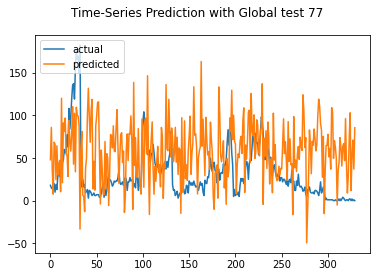

Test MAE: 62.341
Test RMSE: 72.175
Test sMAPE: 110.801
Test R Squared: -4.390
{'mae': 62.3405109911254, 'rmse': 72.17468628998708, 'smape': 110.8014703737956, 'r2': -4.390286032896001}


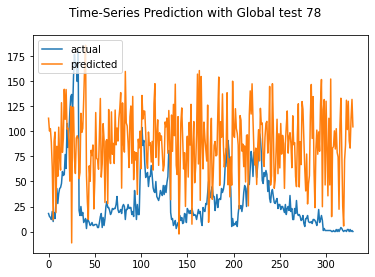

Test MAE: 40.373
Test RMSE: 49.926
Test sMAPE: 101.969
Test R Squared: -1.579
{'mae': 40.37259246995955, 'rmse': 49.92588023207677, 'smape': 101.96903941203246, 'r2': -1.5792501399770118}


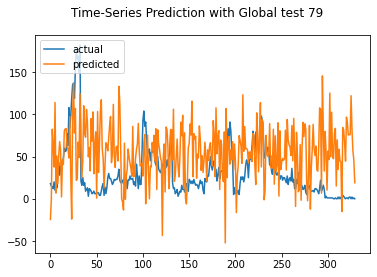

Test MAE: 39.913
Test RMSE: 49.123
Test sMAPE: 98.138
Test R Squared: -1.497
{'mae': 39.91321922486479, 'rmse': 49.12301653635426, 'smape': 98.13848477060921, 'r2': -1.4969627164474706}


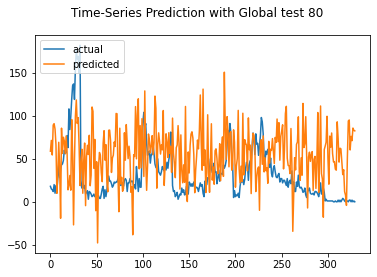

Test MAE: 57.967
Test RMSE: 68.191
Test sMAPE: 110.111
Test R Squared: -3.812
{'mae': 57.96722713004459, 'rmse': 68.19132512958129, 'smape': 110.11122496177563, 'r2': -3.8117190508164835}


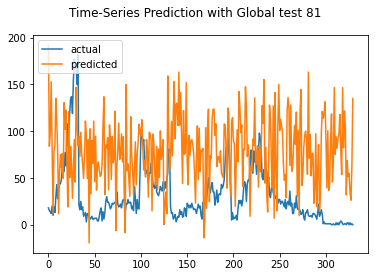

Test MAE: 56.289
Test RMSE: 64.632
Test sMAPE: 108.303
Test R Squared: -3.323
{'mae': 56.28876615943331, 'rmse': 64.63248352224916, 'smape': 108.30327432644911, 'r2': -3.32258647178789}


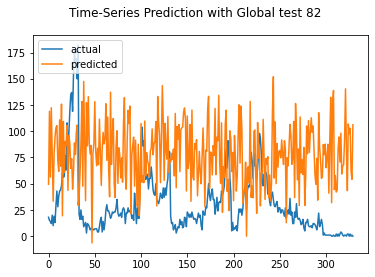

In [ ]:
# Use the Function:
if T != 0: 
    sequence=train_X.shape[1]
    features=train_X.shape[2]
else:
    sequence=T
    features=train_X.shape[1]

calculate_mean_std(lstm_layers, nn_layers, sequence, features, dense_acivation, recurrent_cells, bidirectional, train_X, train_y, test_X, test_y, scalers['scaler_Labels'], monitor=True, plot=None, epochs=50, batch_size=16, n_tests=100, plot_samples=True, Municipality='Global')